# MNIST DATASET

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.The database is also widely used for training and testing in the field of machine learning.It was created by "re-mixing" the samples from NIST's original datasets.

# 1. Importing necessary libraries. 

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from torchvision import transforms,models
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset,ConcatDataset
from torch import nn

# 2. Using pandas library to read the datasets.

In [2]:
train=pd.read_csv("../input/digit-recognizer/train.csv")
test=pd.read_csv("../input/digit-recognizer/test.csv")


# 3. Creating a custom class to load data.

In [3]:
class MnistDataset(Dataset):
    
    def __init__(self, dataframe, 
                 transform = transforms.Compose([transforms.ToTensor()])):
        
        df = dataframe
        self.n_pixels = 784
        
        if len(df.columns) == self.n_pixels:
            # validation data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

# 4. Defining the transforms.

In [4]:
 img_tform_1 = transforms.Compose([
    transforms.ToPILImage(),transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

img_tform_2 = transforms.Compose([
    transforms.ToPILImage(),transforms.RandomRotation(10),transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

img_tform_3 = transforms.Compose([
    transforms.ToPILImage(),transforms.RandomRotation(20),transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

img_tform_4 = transforms.Compose([
    transforms.ToPILImage(),transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.85,0.85)),\
    transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

img_tform_5 = transforms.Compose([
    transforms.ToPILImage(),transforms.RandomAffine(0,shear=30,scale=[1.15,1.15]),\
    transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

img_tform_6 = transforms.Compose([
    transforms.ToPILImage(),transforms.RandomAffine(0,shear=20,scale=[0.8,0.8]),\
    transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

img_tform_7 = transforms.Compose([
    transforms.ToPILImage(),transforms.RandomAffine(degrees=30, scale=(1.2,1.2)),\
    transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])



# 5. Using the defined class and DataLoader to load data into pytorch datasets.

We will be using the batch-size as 64 and num_workers as 4. We use the customized "MNISTDataset" class to convert the data from csv files into a format which is loaded into the dataloader. This is done for both train and validation datasets.

In [5]:
from sklearn.model_selection import train_test_split
seed=42
def create_dataloaders(seed, test_size=0.1, df=train, batch_size=64):
    # Create training set and validation set
    train_df, val_df = train_test_split(df,test_size=test_size,random_state=seed)
    
    # Create Datasets
    train_data_1 = MnistDataset(train_df)
    train_data_2 = MnistDataset(train_df, img_tform_2)
    train_data_3 = MnistDataset(train_df, img_tform_3)
    train_data_4 = MnistDataset(train_df, img_tform_4)
    train_data_5 = MnistDataset(train_df, img_tform_5)
    train_data_6 = MnistDataset(train_df, img_tform_6)
    train_data_7 = MnistDataset(train_df, img_tform_7)
    train_final = ConcatDataset([train_data_1, train_data_2, train_data_3, train_data_4, train_data_5,\
                                   train_data_6,train_data_7])

    val_data = MnistDataset(val_df)
    
    # Create Dataloaders
    train_loader = torch.utils.data.DataLoader(train_final, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader



In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


We will be defining the classes on which we will be predicting. We are having 10 classes consisting of numbers 0-9.

In [7]:
classes = [i for i in range(0,10)]

# 6. Defining the pretrained model.

ResNet, which was proposed in 2015 by researchers at Microsoft Research introduced a new architecture called Residual Network.

Residual Block:
In order to solve the problem of the vanishing/exploding gradient, this architecture introduced the concept called Residual Network. In this network we use a technique called skip connections . The skip connection skips training from a few layers and connects directly to the output.

This network uses a 34-layer plain network architecture inspired by VGG-19 in which then the shortcut connection is added. These shortcut connections then convert the architecture into residual network. 

![](https://media.geeksforgeeks.org/wp-content/uploads/20200424011138/ResNet.PNG)

We tune the number of channels in the first layer of the ResNet to suit the images present in the dataset.
We also add a fully connected layer at the end of the network architecture to make the prediction.

In [8]:
model = models.resnet34(pretrained=True)
model.conv1 = torch.nn.Conv1d(1, 64, (3, 3), (1, 1), (1, 1), bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [9]:
model

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 7. Defining the loss function and optimizer.

We are using a "CrossEntropy" loss function and an "Adam" optimizer while training the model.
We also use a scheduler which decays the learning rate of each parameter group by gamma every step_size epochs. Notice that such decay can happen simultaneously with other changes to the learning rate from outside this scheduler.

In [10]:
if torch.cuda.is_available():
    model.cuda()
    
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),amsgrad=True)
xp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


# 8. Training the defined network.

We will be training our network on 10 epochs.

In [11]:
epochs= 20
valid_loss_min = np.Inf
train_epoch=[]
train_loss_vals=[]
train_acc_vals=[]
valid_epoch=[]
valid_loss_vals=[]
valid_acc_vals=[]
test_loss_val=[]
test_epoch=[]
train_loader, valid_loader= create_dataloaders(seed=seed)
for i in range(epochs):
    model.train()
    train_acc=0
    valid_acc=0
    total=0
    with tqdm(train_loader, unit="batch") as tepoch:
        for data, target in tepoch:
            if torch.cuda.is_available():
                data,target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output=model(data)
            _, predicted = torch.max(output.data, 1)
            train_acc+=((predicted==target).sum().item())
            total += target.size(0)
            loss = criterion(output, target)
            loss.backward()
            train_epoch.append(loss.item())
            optimizer.step()
        
    xp_lr_scheduler.step()
    train_loss_vals.append(sum(train_epoch)/len(train_epoch))
    train_acc_vals.append(100 * train_acc/ total)
    model.eval()
    total=0
    with tqdm(valid_loader, unit="batch") as tepoch:
        for data, target in tepoch:
            if torch.cuda.is_available():
                data,target= data.cuda(),target.cuda()
            output=model(data)
            _, predicted = torch.max(output.data, 1)
            valid_acc+=((predicted==target).sum().item())
            total += target.size(0)
            loss= criterion(output,target)
            valid_epoch.append(loss.item())
    valid_loss_vals.append(sum(valid_epoch)/len(valid_epoch))
    valid_acc_vals.append(100 * valid_acc/ total)
    
    print("epoch:{}\t  training_loss:{}\t  validation_loss:{}\t  train_accuracy:{}\t  validation_accuracy:{}"
          .format(i,train_loss_vals[i],valid_loss_vals[i],train_acc_vals[i],valid_acc_vals[i]))
    if valid_loss_vals[i] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss_vals[i]))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss_vals[i]

 12%|█▏        | 8/66 [00:00<00:00, 70.78batch/s]

Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 66/66 [00:00<00:00, 72.87batch/s]


epoch:0	  training_loss:0.07623350698113196	  validation_loss:0.02449158731156565	  train_accuracy:97.73998488284202	  validation_accuracy:99.21428571428571
Validation loss decreased (inf --> 0.024492).  Saving model ...


 11%|█         | 7/66 [00:00<00:00, 69.15batch/s]

Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 66/66 [00:00<00:00, 72.62batch/s]


epoch:1	  training_loss:0.050219204094864266	  validation_loss:0.023111874389349286	  train_accuracy:99.24565381708238	  validation_accuracy:99.38095238095238
Validation loss decreased (0.024492 --> 0.023112).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 73.37batch/s]

Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 2/4135 [00:00<04:50, 14.21batch/s]

epoch:2	  training_loss:0.03948204159365803	  validation_loss:0.025416045956198372	  train_accuracy:99.45993953136811	  validation_accuracy:99.0952380952381


 12%|█▏        | 8/66 [00:00<00:00, 72.82batch/s]

Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 66/66 [00:00<00:00, 72.51batch/s]


epoch:3	  training_loss:0.03239447287690095	  validation_loss:0.022216833485730825	  train_accuracy:99.66250944822373	  validation_accuracy:99.54761904761905
Validation loss decreased (0.023112 --> 0.022217).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 73.36batch/s]

Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 66/66 [00:00<00:00, 72.95batch/s]


epoch:4	  training_loss:0.027443658599709514	  validation_loss:0.020271428661594242	  train_accuracy:99.76001511715798	  validation_accuracy:99.5952380952381
Validation loss decreased (0.022217 --> 0.020271).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 71.62batch/s]

Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 66/66 [00:00<00:00, 72.59batch/s]


epoch:5	  training_loss:0.023996905455443456	  validation_loss:0.019040364907366415	  train_accuracy:99.79024943310658	  validation_accuracy:99.57142857142857
Validation loss decreased (0.020271 --> 0.019040).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 70.77batch/s]

Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 66/66 [00:00<00:00, 71.28batch/s]


epoch:6	  training_loss:0.021426629329270447	  validation_loss:0.018136488889172436	  train_accuracy:99.81746031746032	  validation_accuracy:99.5952380952381
Validation loss decreased (0.019040 --> 0.018136).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 72.09batch/s]

Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 66/66 [00:00<00:00, 72.65batch/s]


epoch:7	  training_loss:0.019488839815034294	  validation_loss:0.017442577633584155	  train_accuracy:99.81481481481481	  validation_accuracy:99.5952380952381
Validation loss decreased (0.018136 --> 0.017443).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 72.02batch/s]

Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 66/66 [00:01<00:00, 63.38batch/s]


epoch:8	  training_loss:0.017931163504182827	  validation_loss:0.01695903132080618	  train_accuracy:99.83862433862434	  validation_accuracy:99.54761904761905
Validation loss decreased (0.017443 --> 0.016959).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 71.59batch/s]

Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 66/66 [00:00<00:00, 73.12batch/s]


epoch:9	  training_loss:0.016697465174585563	  validation_loss:0.01651473297219623	  train_accuracy:99.8219954648526	  validation_accuracy:99.5952380952381
Validation loss decreased (0.016959 --> 0.016515).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 71.77batch/s]

Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 66/66 [00:00<00:00, 72.75batch/s]


epoch:10	  training_loss:0.015711076628007376	  validation_loss:0.01618532569191102	  train_accuracy:99.82615268329555	  validation_accuracy:99.57142857142857
Validation loss decreased (0.016515 --> 0.016185).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 71.83batch/s]

Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 66/66 [00:00<00:00, 71.92batch/s]


epoch:11	  training_loss:0.014884248094377342	  validation_loss:0.01587656756694769	  train_accuracy:99.8219954648526	  validation_accuracy:99.57142857142857
Validation loss decreased (0.016185 --> 0.015877).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 71.43batch/s]

Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 66/66 [00:01<00:00, 64.47batch/s]


epoch:12	  training_loss:0.014163395239472838	  validation_loss:0.015628162892822636	  train_accuracy:99.83749055177627	  validation_accuracy:99.5952380952381
Validation loss decreased (0.015877 --> 0.015628).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 71.65batch/s]

Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 66/66 [00:00<00:00, 72.51batch/s]


epoch:13	  training_loss:0.013545553254961176	  validation_loss:0.01541906910208985	  train_accuracy:99.83144368858655	  validation_accuracy:99.5952380952381
Validation loss decreased (0.015628 --> 0.015419).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 72.43batch/s]

Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 66/66 [00:00<00:00, 72.45batch/s]


epoch:14	  training_loss:0.013002836567196106	  validation_loss:0.015232527414914468	  train_accuracy:99.82615268329555	  validation_accuracy:99.54761904761905
Validation loss decreased (0.015419 --> 0.015233).  Saving model ...


 12%|█▏        | 8/66 [00:00<00:00, 71.78batch/s]

Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 66/66 [00:00<00:00, 72.00batch/s]


epoch:15	  training_loss:0.012547344218724278	  validation_loss:0.015070692632012637	  train_accuracy:99.81897203325775	  validation_accuracy:99.52380952380952
Validation loss decreased (0.015233 --> 0.015071).  Saving model ...


  9%|▉         | 6/66 [00:00<00:01, 57.30batch/s]

Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 66/66 [00:01<00:00, 60.68batch/s]


epoch:16	  training_loss:0.012143178220220551	  validation_loss:0.014936554048624385	  train_accuracy:99.82766439909297	  validation_accuracy:99.5952380952381
Validation loss decreased (0.015071 --> 0.014937).  Saving model ...


 11%|█         | 7/66 [00:00<00:00, 61.54batch/s]

Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 66/66 [00:01<00:00, 61.09batch/s]


epoch:17	  training_loss:0.011780567104185282	  validation_loss:0.014813967175875407	  train_accuracy:99.82955404383976	  validation_accuracy:99.57142857142857
Validation loss decreased (0.014937 --> 0.014814).  Saving model ...


 11%|█         | 7/66 [00:00<00:00, 61.76batch/s]

Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 66/66 [00:01<00:00, 61.28batch/s]


epoch:18	  training_loss:0.011453769357454015	  validation_loss:0.014708180636080795	  train_accuracy:99.82577475434618	  validation_accuracy:99.5952380952381
Validation loss decreased (0.014814 --> 0.014708).  Saving model ...


 11%|█         | 7/66 [00:00<00:00, 61.71batch/s]

Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 66/66 [00:01<00:00, 60.87batch/s]


epoch:19	  training_loss:0.0111651388576863	  validation_loss:0.014609315859545611	  train_accuracy:99.83824640967498	  validation_accuracy:99.57142857142857
Validation loss decreased (0.014708 --> 0.014609).  Saving model ...


# 9. Saving the model.

In [12]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

# 10. Plotting the train and validation accuracy curves.

Text(0.5, 1.0, 'Accuracy curve')

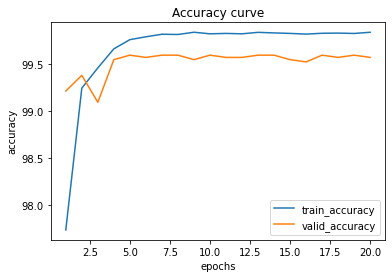

In [13]:
plt.plot(np.linspace(1, epochs, epochs).astype(int), train_acc_vals,label='train_accuracy')
plt.plot(np.linspace(1, epochs, epochs).astype(int), valid_acc_vals,label='valid_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy curve')

# 11. Plotting the train and validation loss curves.

Text(0.5, 1.0, 'loss functions')

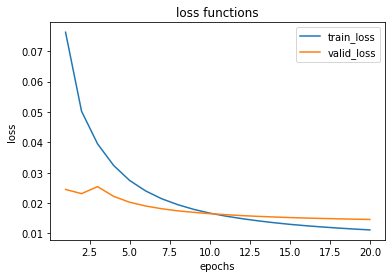

In [14]:
plt.plot(np.linspace(1, epochs, epochs).astype(int), train_loss_vals,label='train_loss')
plt.plot(np.linspace(1, epochs, epochs).astype(int), valid_loss_vals,label='valid_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('loss functions')

# 12. Loading the test data and preprocessing the images.

In [15]:

test_images = test.values.reshape((-1, 1, 28, 28)) / 255.0
print(test_images.shape)

test_image_tensor = torch.tensor(test_images, dtype=torch.float32)

(28000, 1, 28, 28)


# 13. Making the predictions.

In [16]:
model.eval()
result = np.zeros(test_images.shape[0], dtype=np.int64)

with torch.no_grad():
    for i in range(test_images.shape[0]):
        image = test_image_tensor[i, 0, :, :].view(1, 1, 28, 28)
        output=model(image.cuda())
        _, pred = torch.max(output, 1) 
        result[i] = classes[pred.item()]

In [17]:
result[:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

In [18]:
sample_submission=pd.read_csv('../input/digit-recognizer/sample_submission.csv')
sample_submission['Label']=result

In [19]:
sample_submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


# 14. Converting predictions to CSV file and submitting.

In [20]:
sample_submission.to_csv('submission1.csv', index=False)

**With this, we come to the end of the notebook.
Please upvote if you found it useful :)
It motivates me a lot to share more such stuff.**